# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

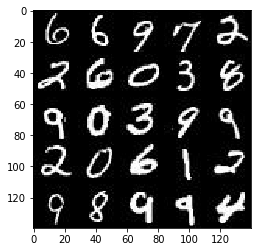

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

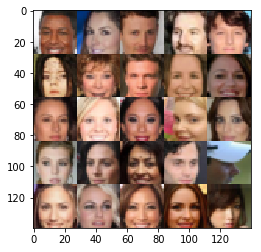

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        conv1 = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 256, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        fc = tf.layers.dense(tf.reshape(conv2, (-1, 4*4*256)), 1)
        
        return tf.sigmoid(fc), fc
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
        fc1 = tf.layers.dense(z, 2*2*256)
        fc1 = tf.reshape(fc1, (-1, 2, 2, 256))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        conv1 = tf.layers.conv2d_transpose(fc1, 128, 5, strides=2, padding='valid')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        
        return tf.tanh(conv3)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g = generator(input_z, out_channel_dim, is_train=True)
    d_real, d_real_logits = discriminator(input_real, reuse=False)
    d_fake, d_fake_logits = discriminator(g, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake)))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits, labels=tf.ones_like(d_real)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits, labels=tf.zeros_like(d_fake)))
    
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real, z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(real, z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2 # - 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={lr: learning_rate, real: batch_images, z: batch_z})
                _ = sess.run(g_opt, feed_dict={lr: learning_rate, real: batch_images, z: batch_z})
                _ = sess.run(g_opt, feed_dict={lr: learning_rate, real: batch_images, z: batch_z})
                
                if i % 100 == 0:
                    show_generator_output(sess, 9, z, data_shape[-1], data_image_mode)
                    
                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {z: batch_z, real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                i += 1
                    
            show_generator_output(sess, 25, z, data_shape[-1], data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

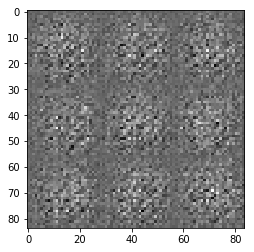

Epoch 1/2... Discriminator Loss: 5.9921... Generator Loss: 0.0028
Epoch 1/2... Discriminator Loss: 4.1477... Generator Loss: 0.0219
Epoch 1/2... Discriminator Loss: 3.4492... Generator Loss: 0.0471
Epoch 1/2... Discriminator Loss: 3.1250... Generator Loss: 0.0750
Epoch 1/2... Discriminator Loss: 1.7943... Generator Loss: 0.2946
Epoch 1/2... Discriminator Loss: 1.7193... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.4077
Epoch 1/2... Discriminator Loss: 1.5537... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.3426


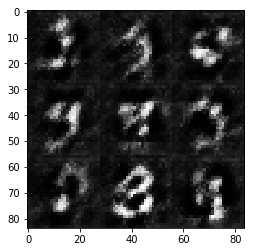

Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.3949
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 0.3231
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.2845
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.4124
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.4154
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.3902


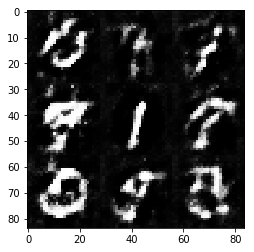

Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.4380
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.3687
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.3441
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.3754
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 1.6653... Generator Loss: 0.2613
Epoch 1/2... Discriminator Loss: 1.6279... Generator Loss: 0.3126
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.3983


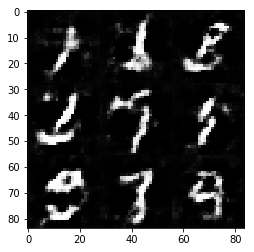

Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.3372
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.3700
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.6358... Generator Loss: 0.2881
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.3760
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.3499


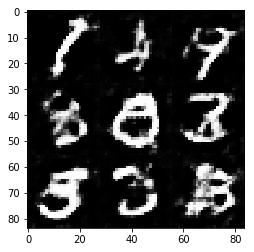

Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.3093
Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 1.1967
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 1.1619
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.9730


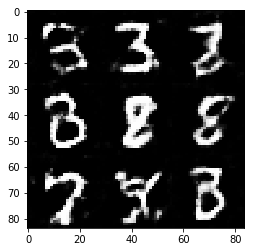

Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 1.1092
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.6928... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.4446


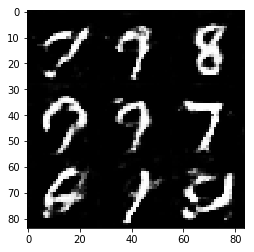

Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 2.2250... Generator Loss: 0.1357
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.3542
Epoch 1/2... Discriminator Loss: 1.5616... Generator Loss: 0.3620
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.3981
Epoch 1/2... Discriminator Loss: 2.1976... Generator Loss: 0.1503
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.3250


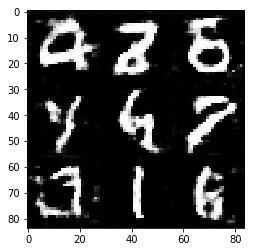

Epoch 1/2... Discriminator Loss: 1.6644... Generator Loss: 0.2747
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.3129
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.6422... Generator Loss: 1.1839
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.9799


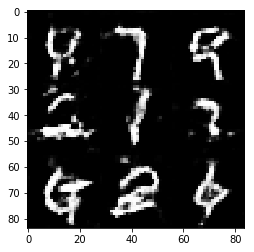

Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.9578
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.9058... Generator Loss: 0.2079
Epoch 1/2... Discriminator Loss: 1.6913... Generator Loss: 0.2641
Epoch 1/2... Discriminator Loss: 2.0264... Generator Loss: 0.1664
Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 0.3306
Epoch 1/2... Discriminator Loss: 1.8797... Generator Loss: 0.2197
Epoch 1/2... Discriminator Loss: 2.0125... Generator Loss: 0.1665
Epoch 1/2... Discriminator Loss: 1.6575... Generator Loss: 0.2791
Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 0.6848


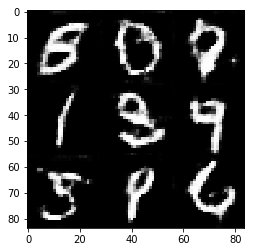

Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.8156... Generator Loss: 0.2300
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.3638


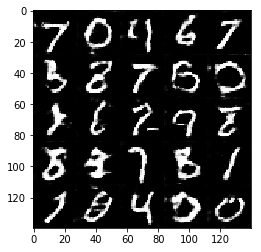

Epoch 2/2... Discriminator Loss: 1.5623... Generator Loss: 1.7090
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 1.5900... Generator Loss: 0.3174
Epoch 2/2... Discriminator Loss: 1.5376... Generator Loss: 0.3271
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 1.1318
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.8915


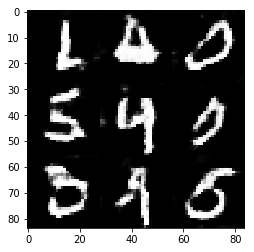

Epoch 2/2... Discriminator Loss: 1.6195... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.3553
Epoch 2/2... Discriminator Loss: 1.5051... Generator Loss: 0.3288
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 1.1130
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 1.3739
Epoch 2/2... Discriminator Loss: 1.6245... Generator Loss: 0.2833


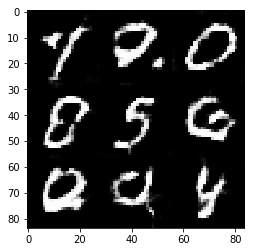

Epoch 2/2... Discriminator Loss: 2.2604... Generator Loss: 0.1270
Epoch 2/2... Discriminator Loss: 1.6260... Generator Loss: 0.2965
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: 1.7089... Generator Loss: 0.2709
Epoch 2/2... Discriminator Loss: 2.0485... Generator Loss: 0.1858
Epoch 2/2... Discriminator Loss: 1.5334... Generator Loss: 0.3389
Epoch 2/2... Discriminator Loss: 2.3402... Generator Loss: 0.1238
Epoch 2/2... Discriminator Loss: 1.5386... Generator Loss: 0.3154
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.3047
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 1.5602


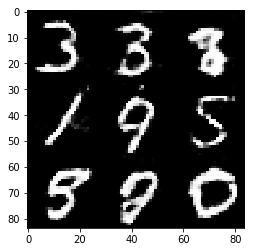

Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.2057
Epoch 2/2... Discriminator Loss: 1.7260... Generator Loss: 0.2526
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.5460
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 1.3227
Epoch 2/2... Discriminator Loss: 2.2472... Generator Loss: 1.8061
Epoch 2/2... Discriminator Loss: 1.4846... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.6158... Generator Loss: 0.3086
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.5060


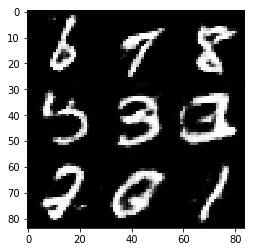

Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 1.6882... Generator Loss: 0.2766
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 2.4217... Generator Loss: 0.1224
Epoch 2/2... Discriminator Loss: 1.8727... Generator Loss: 0.2140
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 1.7915... Generator Loss: 0.2319
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 3.3081... Generator Loss: 0.0553
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 1.0736


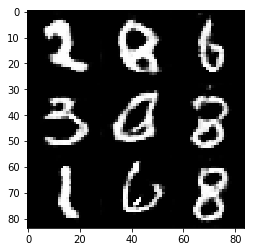

Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.3317
Epoch 2/2... Discriminator Loss: 1.5553... Generator Loss: 0.3147
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.3316
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.6004... Generator Loss: 0.3209
Epoch 2/2... Discriminator Loss: 1.8475... Generator Loss: 0.2644
Epoch 2/2... Discriminator Loss: 1.6928... Generator Loss: 0.2667
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.3385


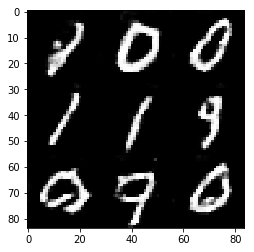

Epoch 2/2... Discriminator Loss: 1.9625... Generator Loss: 0.1966
Epoch 2/2... Discriminator Loss: 1.6618... Generator Loss: 0.2699
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 1.8753
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 1.5734
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 1.8765... Generator Loss: 0.2388
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 1.8902
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 2.2184... Generator Loss: 0.1429
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.3691


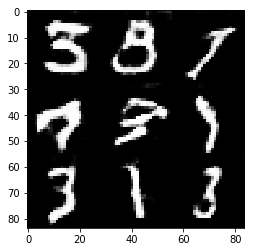

Epoch 2/2... Discriminator Loss: 1.5089... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: 2.0645... Generator Loss: 0.1727
Epoch 2/2... Discriminator Loss: 1.5174... Generator Loss: 0.3733
Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 1.1020
Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.4402
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 1.4060
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 2.4991... Generator Loss: 0.1242
Epoch 2/2... Discriminator Loss: 1.4696... Generator Loss: 0.3496


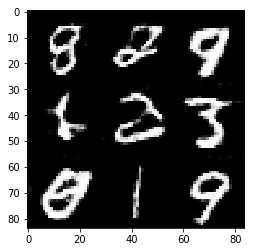

Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.3483
Epoch 2/2... Discriminator Loss: 2.1658... Generator Loss: 0.1593
Epoch 2/2... Discriminator Loss: 1.6196... Generator Loss: 0.3002
Epoch 2/2... Discriminator Loss: 1.7236... Generator Loss: 0.2746
Epoch 2/2... Discriminator Loss: 2.4117... Generator Loss: 0.1285
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.9263... Generator Loss: 0.2253
Epoch 2/2... Discriminator Loss: 1.8902... Generator Loss: 0.2091
Epoch 2/2... Discriminator Loss: 0.7221... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.8405... Generator Loss: 0.2324


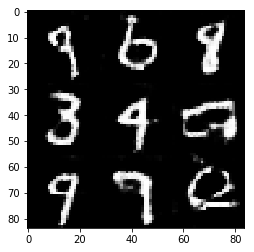

Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 2.2711
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 1.1512
Epoch 2/2... Discriminator Loss: 2.0459... Generator Loss: 0.1804
Epoch 2/2... Discriminator Loss: 2.5933... Generator Loss: 0.1030
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.4037
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.5530... Generator Loss: 0.3146


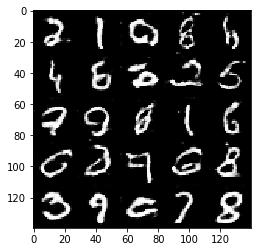

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 5e-4
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

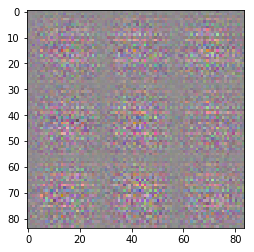

Epoch 1/1... Discriminator Loss: 8.0970... Generator Loss: 0.0004
Epoch 1/1... Discriminator Loss: 4.9480... Generator Loss: 0.0143
Epoch 1/1... Discriminator Loss: 3.1755... Generator Loss: 0.0774
Epoch 1/1... Discriminator Loss: 2.1851... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 2.7437
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.9108
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 2.0520
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 3.1453
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 1.5761


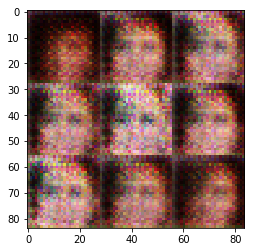

Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 2.2497... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.9409... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.9982... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.9536... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 2.0921... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.6504


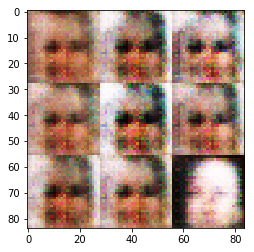

Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8198


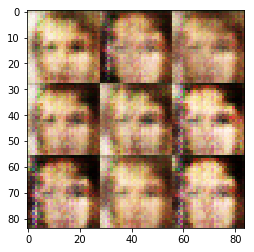

Epoch 1/1... Discriminator Loss: 1.7621... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.6477... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6149


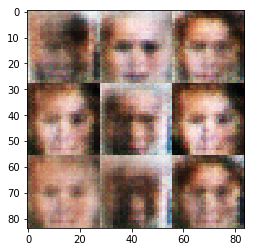

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8669


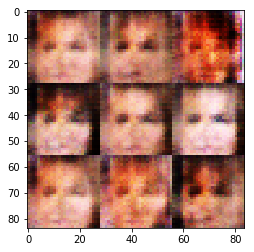

Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.9371... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.7330... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8404


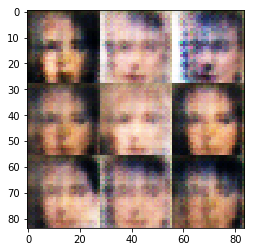

Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6763


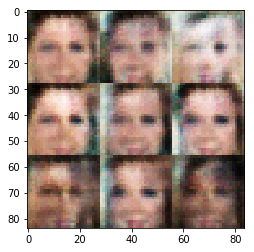

Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8049


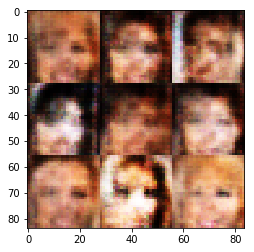

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7463


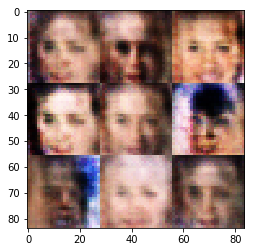

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7885


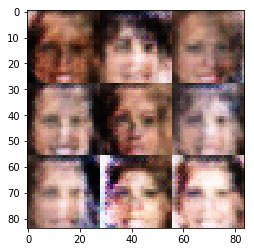

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6673


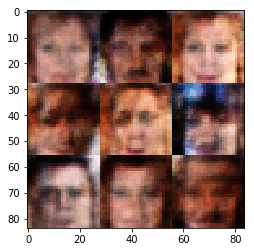

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5310


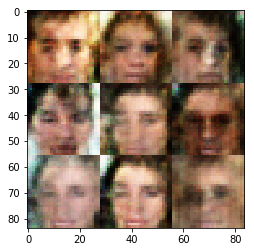

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6094


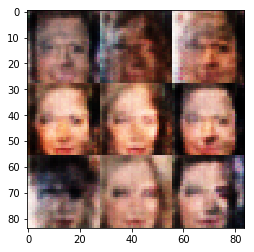

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6346


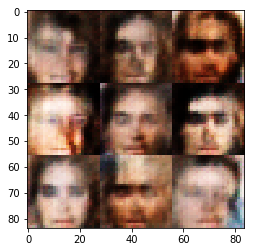

Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6748


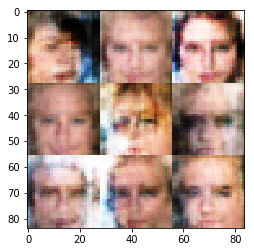

Epoch 1/1... Discriminator Loss: 1.6485... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6936


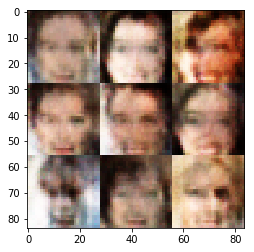

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6776


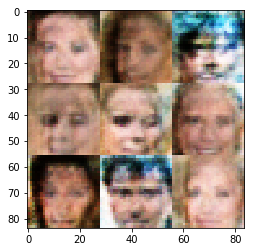

Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7745


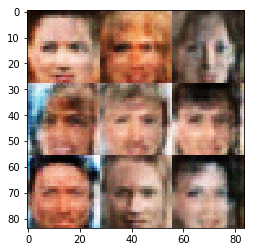

Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7733


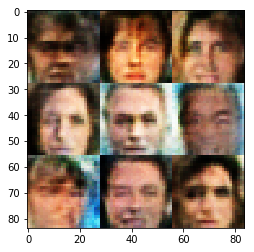

Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6331


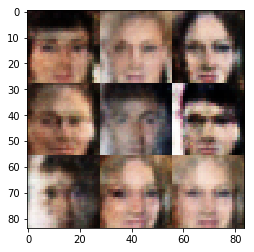

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.5829


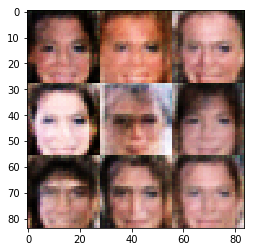

Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6414


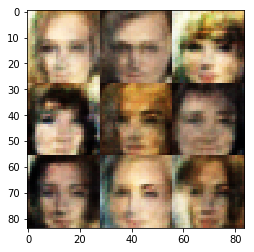

Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6186


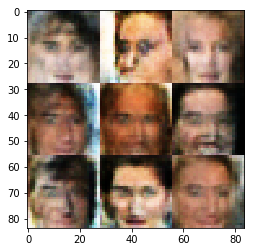

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6615


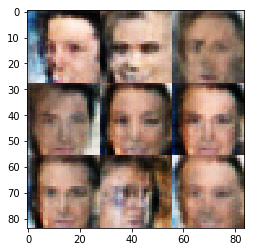

Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5672


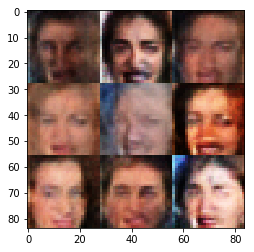

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6704


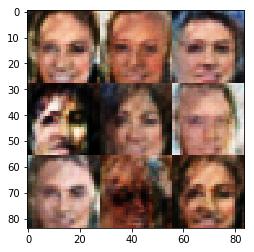

Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7973


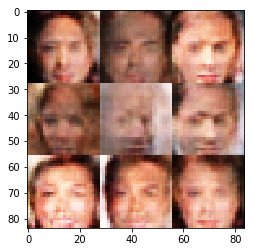

Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6571


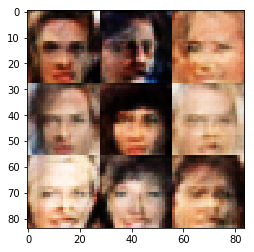

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6184


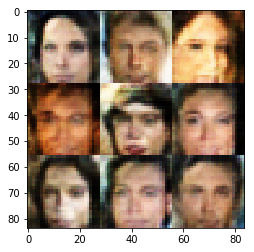

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6408


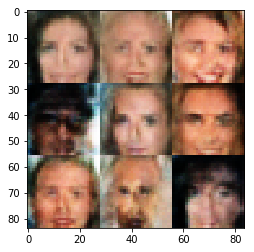

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6748


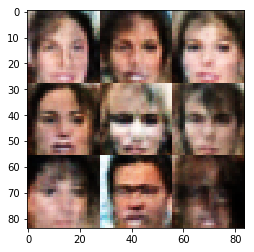

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6451


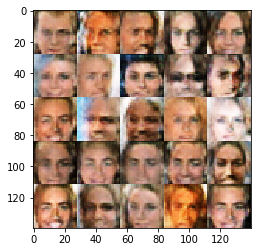

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 5e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.